In [1]:
import matplotlib.pyplot as plt
import cmocean.cm as cm
from veros import veros_routine
from veros import runtime_settings
runtime_settings.backend = 'jax'

from veris.area_mass import SeaIceMass, AreaWS
from veris.dynsolver import WindForcingXY, IceVelocities
from veris.dynamics_routines import SeaIceStrength
from veris.ocean_stress import OceanStressUV
from veris.advection import Advection
from veris.clean_up import clean_up_advection, ridging
from veris.fill_overlap import fill_overlap
from initialize_dyn import state

Importing core modules
 Using computational backend jax on cpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



In [2]:
@veros_routine
def dyn_model(state):
    vs = state.variables

    # calculate sea ice mass centered around c-, u-, and v-points
    vs.SeaIceMassC, vs.SeaIceMassU, vs.SeaIceMassV = SeaIceMass(state)

    # calculate sea ice cover fraction centered around u- and v-points
    vs.AreaW, vs.AreaS = AreaWS(state)

    # calculate surface forcing due to wind
    vs.WindForcingX, vs.WindForcingY = WindForcingXY(state)

    # calculate ice strength
    vs.SeaIceStrength = SeaIceStrength(state)

    # calculate ice velocities
    vs.uIce, vs.vIce, vs.sigma1, vs.sigma2, vs.sigma12 = IceVelocities(state)

    # calculate stresses on ocean surface
    vs.OceanStressU, vs.OceanStressV = OceanStressUV(state)

    # calculate change in sea ice fields due to advection
    vs.hIceMean, vs.hSnowMean, vs.Area = Advection(state)

    # correct overshoots and other pathological cases after advection
    (
        vs.hIceMean,
        vs.hSnowMean,
        vs.Area,
        vs.TSurf,
        vs.os_hIceMean,
        vs.os_hSnowMean,
    ) = clean_up_advection(state)

    # cut off ice cover fraction at 1 after advection
    vs.Area = ridging(state)

    # fill overlaps
    vs.hIceMean = fill_overlap(state,vs.hIceMean)
    vs.hSnowMean = fill_overlap(state,vs.hSnowMean)
    vs.Area = fill_overlap(state,vs.Area)

In [3]:
for n_timesteps in range(200):
    dyn_model(state)

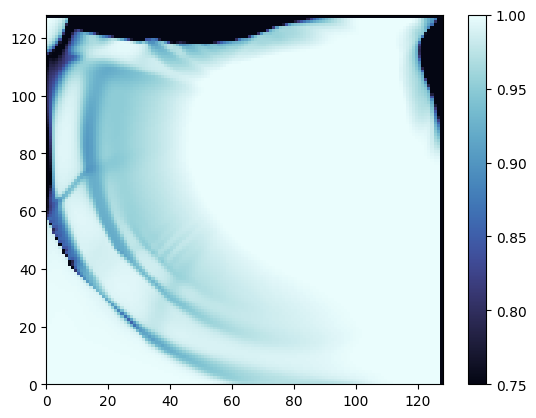

In [ ]:
vs = state.variables

var = vs.Area.T

plt.pcolormesh(var[2:-2,2:-2], cmap=cm.ice, vmin=0.75, vmax=1)
plt.colorbar()